# GRACE Data Exploration for Groundwater Downscaling

This notebook explores the GRACE and auxiliary datasets used for groundwater downscaling in the Mississippi region.

In [1]:
# Standard imports
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from datetime import datetime

# Add the src directory to the path
notebook_dir = Path(os.getcwd())
src_dir = notebook_dir.parent
sys.path.append(str(src_dir))

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("notebook", font_scale=1.2)

# Define directories
data_dir = src_dir / 'data'
raw_dir = data_dir / 'raw'
processed_dir = data_dir / 'processed'
figures_dir = src_dir / 'figures'

# Create directories if they don't exist
figures_dir.mkdir(parents=True, exist_ok=True)

## Initialize Google Earth Engine

First, we need to initialize Google Earth Engine to access GRACE and other datasets.

In [2]:
# Import Earth Engine modules
from src.data.earth_engine import initialize_earth_engine, get_region_geometry, display_region

# Initialize Earth Engine
initialize_earth_engine()

True

## Get Region Geometry

We'll focus on Mississippi as our study area.

In [4]:
# Get Mississippi geometry
region_name = "Mississippi"
mississippi = get_region_geometry(region_name)

# Display region
m = display_region(mississippi, region_name)
m

Map(center=[32.697067781076704, -89.65518265012], controls=(WidgetControl(options=['position', 'transparent_bg…

## Explore GRACE Data

Let's explore the GRACE terrestrial water storage anomalies for our region.

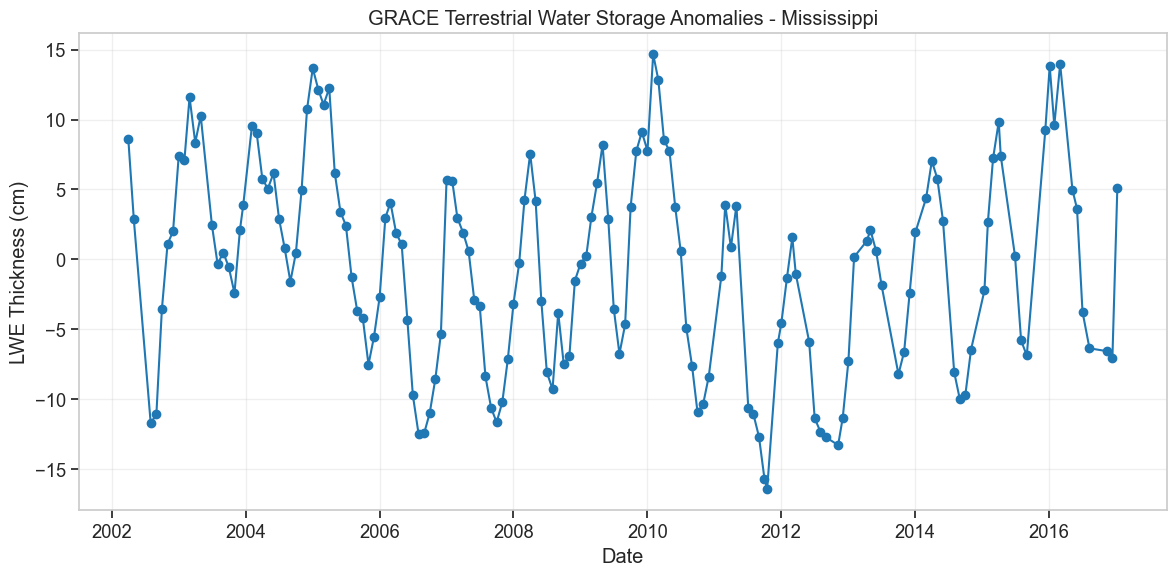

In [5]:
from src.data.grace import get_grace_collection, filter_grace_collection, extract_grace_time_series

# Define date range
start_date = '2002-04-01'
end_date = '2023-01-01'

# Get GRACE data
grace = get_grace_collection('JPL')
grace_filtered = filter_grace_collection(grace, start_date, end_date)

# Extract time series
grace_ts = extract_grace_time_series(grace_filtered, mississippi)

# Plot time series
plt.figure(figsize=(12, 6))
plt.plot(grace_ts['date'], grace_ts['value'], 'o-', color='#1f77b4')
plt.title('GRACE Terrestrial Water Storage Anomalies - Mississippi')
plt.xlabel('Date')
plt.ylabel('LWE Thickness (cm)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(str(figures_dir / 'grace_time_series.png'), dpi=300, bbox_inches='tight')
plt.show()

## Explore Auxiliary Data

Now let's look at the auxiliary datasets: soil moisture, precipitation, and evapotranspiration.

In [6]:
from src.data.auxiliary import (
    get_soil_moisture_collection, get_precipitation_collection, get_evapotranspiration_collection,
    filter_collection, extract_time_series
)

# Get soil moisture data
sm_collection = get_soil_moisture_collection('smap')
sm_filtered = filter_collection(sm_collection, '2015-04-01', end_date, 'ssm')
sm_ts = extract_time_series(sm_filtered, mississippi, band_name='ssm')

# Get precipitation data
precip_collection = get_precipitation_collection('chirps')
precip_filtered = filter_collection(precip_collection, start_date, end_date, 'precipitation')
precip_ts = extract_time_series(precip_filtered, mississippi, band_name='precipitation')

# Get evapotranspiration data
et_collection = get_evapotranspiration_collection('modis')
et_filtered = filter_collection(et_collection, start_date, end_date, 'ET')
et_ts = extract_time_series(et_filtered, mississippi, band_name='ET')

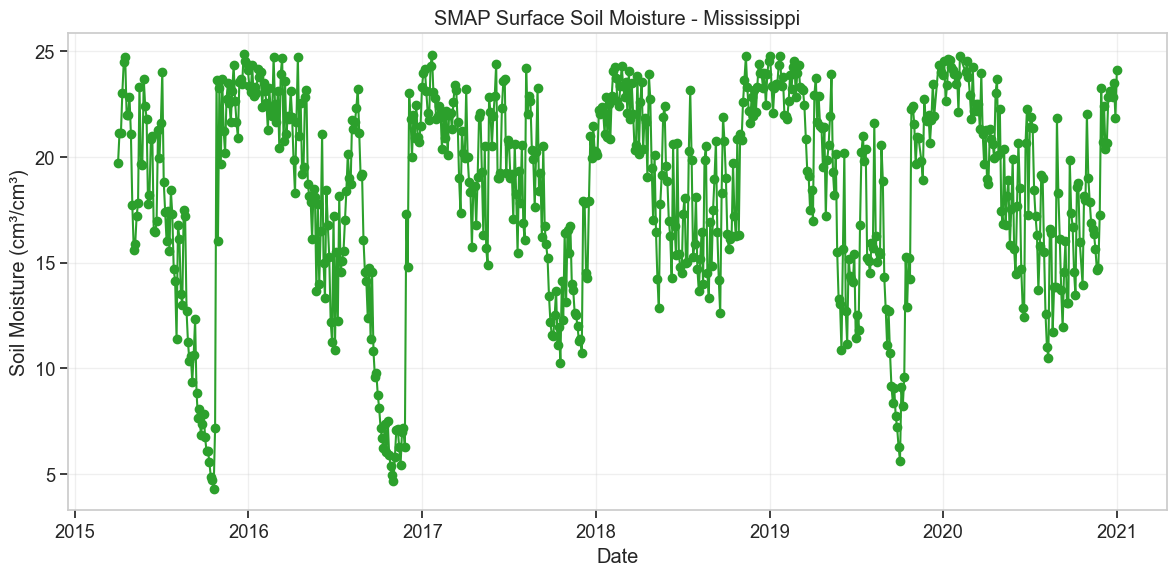

In [7]:
# Plot soil moisture time series
plt.figure(figsize=(12, 6))
plt.plot(sm_ts['date'], sm_ts['value'], 'o-', color='#2ca02c')
plt.title('SMAP Surface Soil Moisture - Mississippi')
plt.xlabel('Date')
plt.ylabel('Soil Moisture (cm³/cm³)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(str(figures_dir / 'soil_moisture_time_series.png'), dpi=300, bbox_inches='tight')
plt.show()

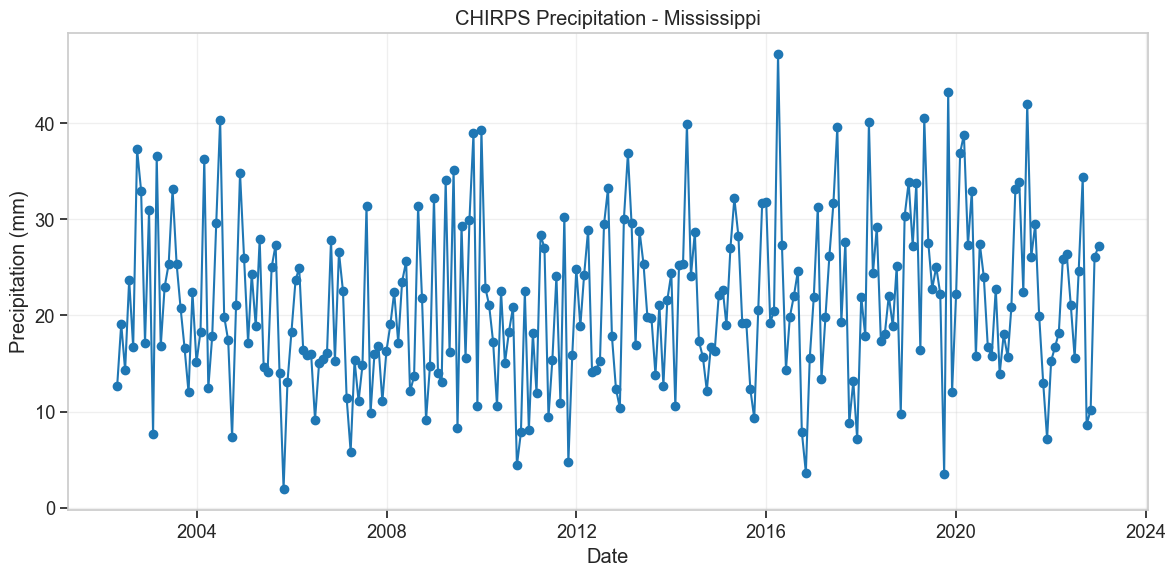

In [8]:
# Plot precipitation time series
# Aggregate by month for better visualization
precip_monthly = precip_ts.set_index('date').resample('M').mean().reset_index()

plt.figure(figsize=(12, 6))
plt.plot(precip_monthly['date'], precip_monthly['value'], 'o-', color='#1f77b4')
plt.title('CHIRPS Precipitation - Mississippi')
plt.xlabel('Date')
plt.ylabel('Precipitation (mm)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(str(figures_dir / 'precipitation_time_series.png'), dpi=300, bbox_inches='tight')
plt.show()

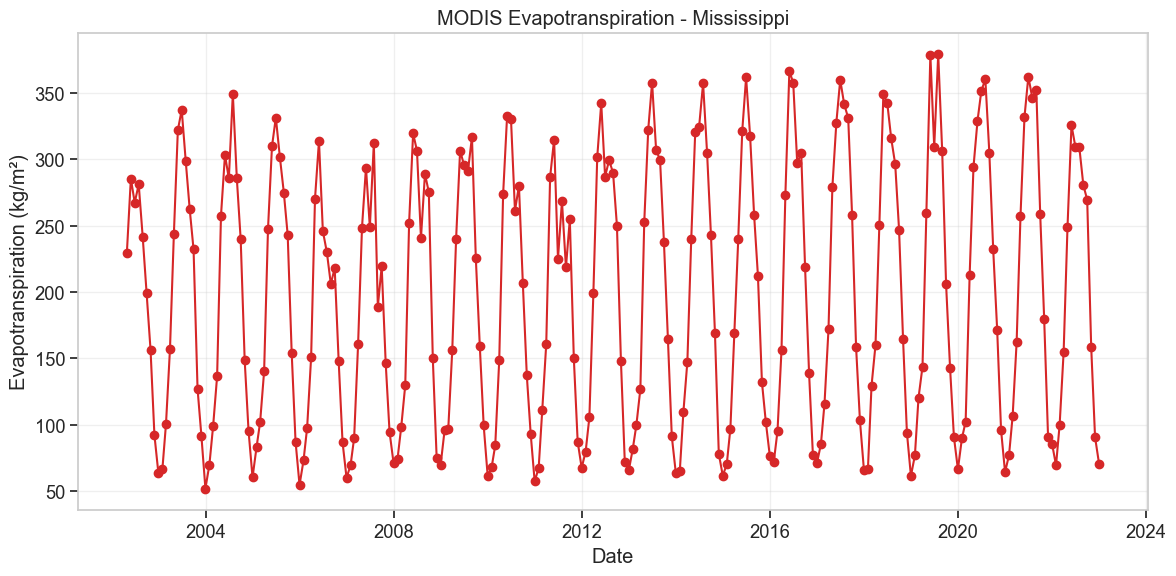

In [9]:
# Plot evapotranspiration time series
# Aggregate by month for better visualization
et_monthly = et_ts.set_index('date').resample('M').mean().reset_index()

plt.figure(figsize=(12, 6))
plt.plot(et_monthly['date'], et_monthly['value'], 'o-', color='#d62728')
plt.title('MODIS Evapotranspiration - Mississippi')
plt.xlabel('Date')
plt.ylabel('Evapotranspiration (kg/m²)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(str(figures_dir / 'evapotranspiration_time_series.png'), dpi=300, bbox_inches='tight')
plt.show()

## Explore USGS Groundwater Data

Let's look at the USGS groundwater well data for Mississippi.

In [10]:
from src.data.usgs import get_usgs_groundwater_data, convert_to_geodataframe

# Get groundwater data
gw_data = get_usgs_groundwater_data('MS', start_date, end_date)

# Convert to GeoDataFrame
gw_gdf = convert_to_geodataframe(gw_data)

In [11]:
# Display well locations
import folium
from folium.plugins import MarkerCluster

# Create a map centered on Mississippi
map_center = [gw_gdf['latitude'].mean(), gw_gdf['longitude'].mean()]
m = folium.Map(location=map_center, zoom_start=7)

# Add a marker cluster
marker_cluster = MarkerCluster().add_to(m)

# Add markers for each well
for idx, row in gw_gdf.drop_duplicates(['site_code', 'latitude', 'longitude']).iterrows():
    folium.Marker(
        location=[row['latitude'], row['longitude']],
        popup=f"<b>Site:</b> {row['site_name']}<br><b>Code:</b> {row['site_code']}",
        icon=folium.Icon(color='blue', icon='water', prefix='fa')
    ).add_to(marker_cluster)

# Display map
m

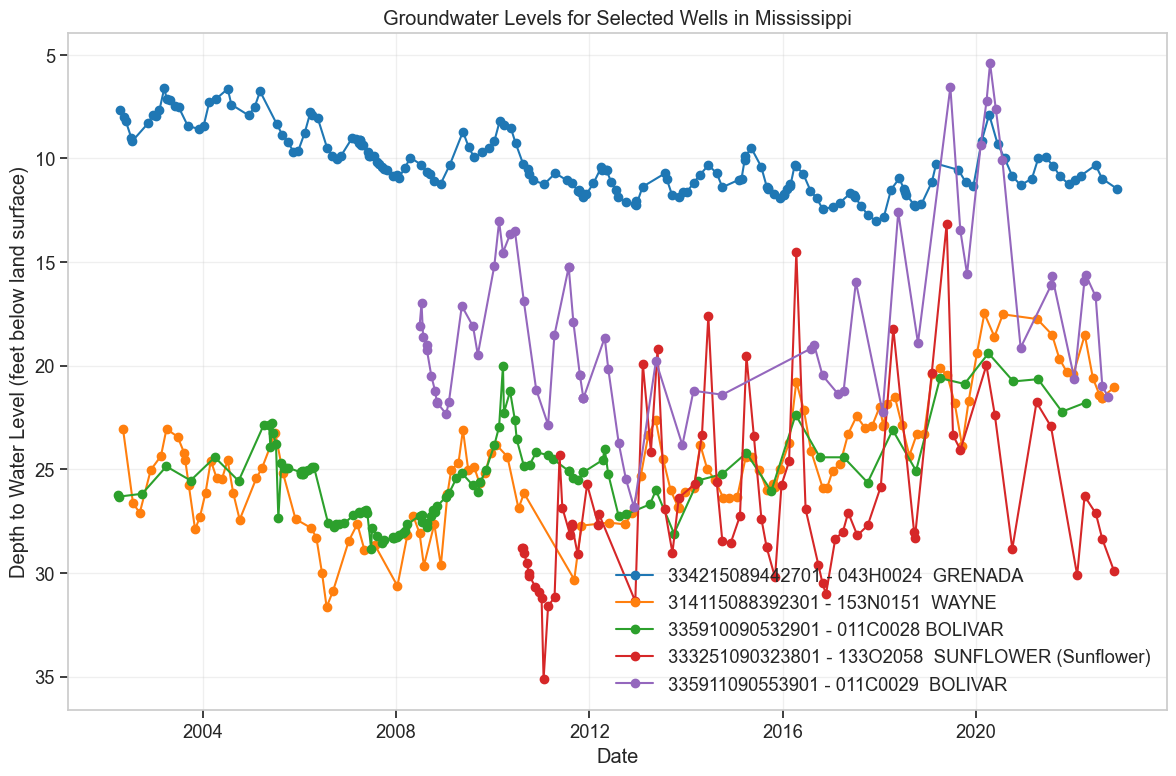

In [12]:
# Plot time series for a few selected wells
# Get the wells with most measurements
well_counts = gw_data.groupby('site_code').size().sort_values(ascending=False)
top_wells = well_counts.head(5).index.tolist()

plt.figure(figsize=(12, 8))

for well in top_wells:
    well_data = gw_data[gw_data['site_code'] == well]
    well_name = well_data['site_name'].iloc[0]
    plt.plot(well_data['date'], well_data['value'], 'o-', label=f"{well} - {well_name}")

plt.title('Groundwater Levels for Selected Wells in Mississippi')
plt.xlabel('Date')
plt.ylabel('Depth to Water Level (feet below land surface)')
plt.gca().invert_yaxis()  # Invert y-axis so higher values (deeper) are lower on plot
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(str(figures_dir / 'groundwater_well_time_series.png'), dpi=300, bbox_inches='tight')
plt.show()

## Compare GRACE with Groundwater Levels

Now let's compare GRACE data with groundwater levels to explore their relationship.

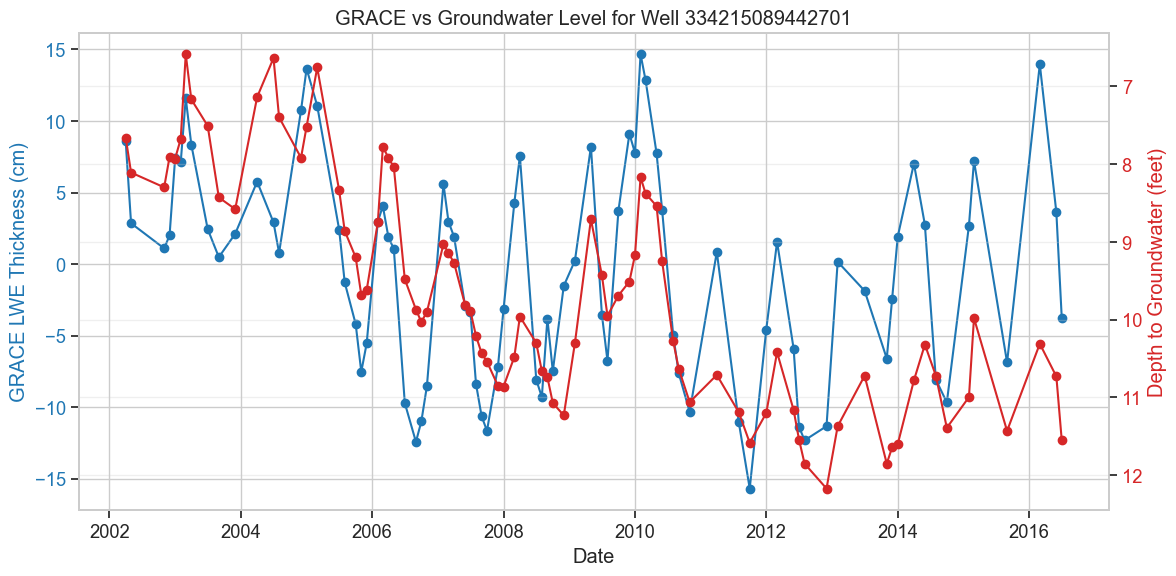

Correlation between GRACE and groundwater level: -0.6434


In [13]:
# Aggregate groundwater data to monthly values for comparison with GRACE
from src.data.usgs import get_monthly_aggregation

gw_monthly = get_monthly_aggregation(gw_data)

# Get data for a well with good temporal coverage
well_data = gw_monthly[gw_monthly['site_code'] == top_wells[0]]

# Prepare GRACE data for comparison
grace_monthly = grace_ts.copy()
grace_monthly['date'] = pd.to_datetime(grace_monthly['date'])

# Merge datasets
comparison_df = pd.merge(
    grace_monthly[['date', 'value']].rename(columns={'value': 'grace'}),
    well_data[['date', 'value']].rename(columns={'value': 'groundwater'}),
    on='date',
    how='inner'
)

# Plot comparison
fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.set_xlabel('Date')
ax1.set_ylabel('GRACE LWE Thickness (cm)', color='#1f77b4')
ax1.plot(comparison_df['date'], comparison_df['grace'], 'o-', color='#1f77b4')
ax1.tick_params(axis='y', labelcolor='#1f77b4')

ax2 = ax1.twinx()
ax2.set_ylabel('Depth to Groundwater (feet)', color='#d62728')
ax2.plot(comparison_df['date'], comparison_df['groundwater'], 'o-', color='#d62728')
ax2.tick_params(axis='y', labelcolor='#d62728')
ax2.invert_yaxis()  # Invert y-axis for groundwater depth

plt.title(f'GRACE vs Groundwater Level for Well {top_wells[0]}')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(str(figures_dir / 'grace_vs_groundwater.png'), dpi=300, bbox_inches='tight')
plt.show()

# Calculate correlation
correlation = comparison_df['grace'].corr(comparison_df['groundwater'])
print(f"Correlation between GRACE and groundwater level: {correlation:.4f}")

## Conclusion

This notebook has explored the key datasets for GRACE groundwater downscaling in Mississippi:

1. GRACE terrestrial water storage anomalies
2. Auxiliary datasets (soil moisture, precipitation, evapotranspiration)
3. USGS groundwater well measurements

These datasets will be used to train a CNN model for downscaling GRACE data to high-resolution groundwater estimates.